In [1]:
import os
import math
import numpy as np
import h5py
import glob
from tqdm import tqdm
import scipy

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
import sklearn.metrics as metrics

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
plt.ion()

Using Theano backend.


In [2]:
model_file = 'model_files/sqn_weights.h5'

In [3]:
W = h5py.File(model_file,'r')
np.array(W['graph']['param_0'])

array([[[[ -7.05284486e-03,   2.31055059e-02,   5.82087450e-02, ...,
            7.69164190e-02,   3.52777652e-02,   4.16628830e-02],
         [  1.52865592e-02,   8.59461948e-02,   8.37313384e-02, ...,
           -1.07828714e-01,  -6.86139017e-02,   6.05410384e-03],
         [  9.80505254e-04,  -5.18188849e-02,  -1.71288282e-01, ...,
           -6.94037527e-02,   3.11834868e-02,   3.07625327e-02],
         ..., 
         [  1.15398476e-02,   4.97442670e-02,   6.88867420e-02, ...,
           -3.96863855e-02,  -1.97296143e-02,  -2.23278748e-05],
         [  1.58716869e-02,   3.82632799e-02,   7.58229196e-03, ...,
           -3.07018440e-02,  -1.60122756e-02,  -1.41809126e-02],
         [  5.37561066e-03,  -1.59728881e-02,  -5.94849661e-02, ...,
           -3.61275300e-02,  -4.99207387e-03,  -3.78917716e-03]],

        [[  9.28471424e-03,   8.05828348e-02,   1.31487995e-01, ...,
            1.03081420e-01,   2.99746655e-02,   2.92896759e-02],
         [  8.34952667e-02,   1.56786650e-01,

In [4]:
all_w = []
for i in range(52):
    k = 'param_{0}'.format(i)
    all_w.append(np.array(W['graph'][k]))

In [5]:
W['graph']

<HDF5 group "/graph" (52 members)>

In [6]:
list(W['graph'].keys())

['param_0',
 'param_1',
 'param_10',
 'param_11',
 'param_12',
 'param_13',
 'param_14',
 'param_15',
 'param_16',
 'param_17',
 'param_18',
 'param_19',
 'param_2',
 'param_20',
 'param_21',
 'param_22',
 'param_23',
 'param_24',
 'param_25',
 'param_26',
 'param_27',
 'param_28',
 'param_29',
 'param_3',
 'param_30',
 'param_31',
 'param_32',
 'param_33',
 'param_34',
 'param_35',
 'param_36',
 'param_37',
 'param_38',
 'param_39',
 'param_4',
 'param_40',
 'param_41',
 'param_42',
 'param_43',
 'param_44',
 'param_45',
 'param_46',
 'param_47',
 'param_48',
 'param_49',
 'param_5',
 'param_50',
 'param_51',
 'param_6',
 'param_7',
 'param_8',
 'param_9']

In [7]:
all_w

[array([[[[ -7.05284486e-03,   2.31055059e-02,   5.82087450e-02, ...,
             7.69164190e-02,   3.52777652e-02,   4.16628830e-02],
          [  1.52865592e-02,   8.59461948e-02,   8.37313384e-02, ...,
            -1.07828714e-01,  -6.86139017e-02,   6.05410384e-03],
          [  9.80505254e-04,  -5.18188849e-02,  -1.71288282e-01, ...,
            -6.94037527e-02,   3.11834868e-02,   3.07625327e-02],
          ..., 
          [  1.15398476e-02,   4.97442670e-02,   6.88867420e-02, ...,
            -3.96863855e-02,  -1.97296143e-02,  -2.23278748e-05],
          [  1.58716869e-02,   3.82632799e-02,   7.58229196e-03, ...,
            -3.07018440e-02,  -1.60122756e-02,  -1.41809126e-02],
          [  5.37561066e-03,  -1.59728881e-02,  -5.94849661e-02, ...,
            -3.61275300e-02,  -4.99207387e-03,  -3.78917716e-03]],
 
         [[  9.28471424e-03,   8.05828348e-02,   1.31487995e-01, ...,
             1.03081420e-01,   2.99746655e-02,   2.92896759e-02],
          [  8.34952667e-02, 

In [13]:
import models

In [17]:
from trans import get_squeezenet

In [18]:
M = get_squeezenet(10,(64,64))

In [19]:
M

In [20]:
w = M.get_weights()[0]

In [21]:
w.shape

(96, 3, 7, 7)

In [22]:
w

array([[[[  2.47145677e-03,   2.52036210e-02,   1.53904082e-02, ...,
            6.63223816e-03,   1.55326976e-02,   1.87553205e-02],
         [ -2.49596173e-03,   1.53503483e-02,   5.07079484e-03, ...,
            1.65592600e-02,   2.02374887e-02,   1.88702531e-02],
         [ -1.22795310e-02,  -4.36983071e-03,   1.04999663e-02, ...,
            3.35087366e-02,   1.18432269e-02,   2.14420799e-02],
         ..., 
         [ -8.04946478e-03,   3.29819694e-02,   1.21755591e-02, ...,
            3.17210774e-03,  -2.79503595e-02,  -3.48256528e-02],
         [ -3.87759786e-03,  -2.92591155e-02,  -1.15358774e-02, ...,
           -1.60964597e-02,   1.37227913e-02,  -1.64643265e-02],
         [  8.55714825e-05,  -2.70207077e-02,  -8.13846570e-03, ...,
           -2.25947071e-02,   1.61877740e-02,  -4.22307057e-03]],

        [[ -9.85309668e-03,  -3.41252275e-02,   8.61154404e-03, ...,
           -1.07556581e-02,   2.27137040e-02,   1.31473457e-02],
         [ -1.96166616e-02,  -1.68518834e-02,

[That took like two hours to update conda's keras]

In [23]:
W = M.get_weights()
for i in range(52):
    if W[i].shape == all_w[i].shape:
        print(i,W[i].shape,all_w[i].shape)

0 (96, 3, 7, 7) (96, 3, 7, 7)
1 (96,) (96,)
2 (16, 96, 1, 1) (16, 96, 1, 1)
3 (16,) (16,)
4 (64, 16, 1, 1) (64, 16, 1, 1)
5 (64,) (64,)
6 (64, 16, 3, 3) (64, 16, 3, 3)
7 (64,) (64,)
8 (16, 128, 1, 1) (16, 128, 1, 1)
9 (16,) (16,)
10 (64, 16, 1, 1) (64, 16, 1, 1)
11 (64,) (64,)
12 (64, 16, 3, 3) (64, 16, 3, 3)
13 (64,) (64,)
14 (32, 128, 1, 1) (32, 128, 1, 1)
15 (32,) (32,)
16 (128, 32, 1, 1) (128, 32, 1, 1)
17 (128,) (128,)
18 (128, 32, 3, 3) (128, 32, 3, 3)
19 (128,) (128,)
20 (32, 256, 1, 1) (32, 256, 1, 1)
21 (32,) (32,)
27 (48,) (48,)
28 (192, 48, 1, 1) (192, 48, 1, 1)
29 (192,) (192,)
30 (192, 48, 3, 3) (192, 48, 3, 3)
31 (192,) (192,)
32 (48, 384, 1, 1) (48, 384, 1, 1)
33 (48,) (48,)
34 (192, 48, 1, 1) (192, 48, 1, 1)
35 (192,) (192,)
36 (192, 48, 3, 3) (192, 48, 3, 3)
37 (192,) (192,)
38 (64, 384, 1, 1) (64, 384, 1, 1)
39 (64,) (64,)
40 (256, 64, 1, 1) (256, 64, 1, 1)
41 (256,) (256,)
42 (256, 64, 3, 3) (256, 64, 3, 3)
43 (256,) (256,)
44 (64, 512, 1, 1) (64, 512, 1, 1)
45 (64,)

In [24]:
M.set_weights?

In [25]:
M.set_weights(all_w)

In [26]:
M.get_weights()

[array([[[[ -7.05284486e-03,   2.31055059e-02,   5.82087450e-02, ...,
             7.69164190e-02,   3.52777652e-02,   4.16628830e-02],
          [  1.52865592e-02,   8.59461948e-02,   8.37313384e-02, ...,
            -1.07828714e-01,  -6.86139017e-02,   6.05410384e-03],
          [  9.80505254e-04,  -5.18188849e-02,  -1.71288282e-01, ...,
            -6.94037527e-02,   3.11834868e-02,   3.07625327e-02],
          ..., 
          [  1.15398476e-02,   4.97442670e-02,   6.88867420e-02, ...,
            -3.96863855e-02,  -1.97296143e-02,  -2.23278748e-05],
          [  1.58716869e-02,   3.82632799e-02,   7.58229196e-03, ...,
            -3.07018440e-02,  -1.60122756e-02,  -1.41809126e-02],
          [  5.37561066e-03,  -1.59728881e-02,  -5.94849661e-02, ...,
            -3.61275300e-02,  -4.99207387e-03,  -3.78917716e-03]],
 
         [[  9.28471424e-03,   8.05828348e-02,   1.31487995e-01, ...,
             1.03081420e-01,   2.99746655e-02,   2.92896759e-02],
          [  8.34952667e-02, 

In [27]:
M.get_weights()[-2]

array([[-0.0994117 , -0.17339723, -0.48833382,  0.1304256 ,  0.44376141,
        -0.49287677, -0.19702327,  0.00832313,  0.44942853, -0.09508913],
       [ 0.23246226, -0.17011692,  0.53195775, -0.27005115,  0.40599969,
        -0.22973415, -0.41582179,  0.10971434, -0.08478212,  0.42563722],
       [ 0.03388389, -0.40116823,  0.32483   ,  0.40100193,  0.34423944,
        -0.26100934, -0.16065176,  0.50500631, -0.12219324, -0.35965803],
       [ 0.09097328, -0.35666797,  0.17769344,  0.09588049, -0.08904858,
        -0.46129373, -0.35299128,  0.37910649,  0.44134074,  0.05836181],
       [ 0.51431811, -0.28133908,  0.34984872,  0.03432058, -0.05340034,
        -0.0201256 ,  0.19035818,  0.45861313, -0.50809592,  0.13401486],
       [ 0.34966716,  0.19015403, -0.12448037,  0.16245995, -0.01862562,
        -0.33470845, -0.07941512,  0.05698345, -0.2989541 , -0.34584165],
       [ 0.07795989, -0.11297882, -0.41965878, -0.29833651, -0.1413974 ,
        -0.13717175, -0.22396615, -0.39803612

In [28]:
all_w[0]

array([[[[ -7.05284486e-03,   2.31055059e-02,   5.82087450e-02, ...,
            7.69164190e-02,   3.52777652e-02,   4.16628830e-02],
         [  1.52865592e-02,   8.59461948e-02,   8.37313384e-02, ...,
           -1.07828714e-01,  -6.86139017e-02,   6.05410384e-03],
         [  9.80505254e-04,  -5.18188849e-02,  -1.71288282e-01, ...,
           -6.94037527e-02,   3.11834868e-02,   3.07625327e-02],
         ..., 
         [  1.15398476e-02,   4.97442670e-02,   6.88867420e-02, ...,
           -3.96863855e-02,  -1.97296143e-02,  -2.23278748e-05],
         [  1.58716869e-02,   3.82632799e-02,   7.58229196e-03, ...,
           -3.07018440e-02,  -1.60122756e-02,  -1.41809126e-02],
         [  5.37561066e-03,  -1.59728881e-02,  -5.94849661e-02, ...,
           -3.61275300e-02,  -4.99207387e-03,  -3.78917716e-03]],

        [[  9.28471424e-03,   8.05828348e-02,   1.31487995e-01, ...,
            1.03081420e-01,   2.99746655e-02,   2.92896759e-02],
         [  8.34952667e-02,   1.56786650e-01,

In [29]:
M.get_weights()[1]

array([-0.02359771, -0.02166715, -0.02832884,  0.01103144,  0.05279922,
        0.01420272, -0.00452146, -0.02736655, -0.03968554, -0.00495814,
        0.02707799,  0.0314565 ,  0.01072243, -0.00353249,  0.01790579,
        0.01536708, -0.01327585,  0.05037367, -0.01308647, -0.02002533,
        0.0730872 ,  0.03275291, -0.01184585, -0.0228077 ,  0.02073517,
        0.00545883,  0.00045812, -0.00363548,  0.0326946 , -0.02330572,
        0.00832632,  0.01677583, -0.02557491,  0.06141071,  0.01790133,
       -0.02914691, -0.0029927 , -0.01927762, -0.00746101, -0.02894968,
       -0.03984156, -0.01689536,  0.05610183, -0.01018201, -0.02881709,
       -0.00757139, -0.00639037,  0.01442221,  0.01697708, -0.01996794,
        0.00357894, -0.00526429, -0.02547801, -0.0041472 ,  0.04286802,
        0.00701048, -0.01688768,  0.01277951,  0.0067844 , -0.0156045 ,
       -0.02227778,  0.00570327,  0.02567052, -0.02418983, -0.00937154,
       -0.00352569,  0.01447939,  0.03055013, -0.012468  , -0.01

## Incorporate otto.py

In [30]:
import os
import math
import numpy as np
import h5py
import glob
import scipy
import scipy.misc
import random

import argparse

In [31]:
parser = argparse.ArgumentParser(description='Steer Otto, the autonomous tractor.')
parser.add_argument('-d','--debug', action='store_true', default=False)
parser.add_argument('-n','--no-video', action='store_true', default=False)
parser.add_argument('-f','--failsafe', action='store_true', default=False)

args = parser.parse_args()
debug = args.debug
video = not args.no_video 
failsafe = args.failsafe

usage: __main__.py [-h] [-d] [-n] [-f]
__main__.py: error: unrecognized arguments: /run/user/1000/jupyter/kernel-3f4aabfa-ccad-47d8-a7f9-f669b3cc4fb9.json


SystemExit: 2

/home/franciscodeaqui/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Add in simplesteer.py

In [32]:
import serial

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, activity_l2, l1
from keras.utils.np_utils import to_categorical
from keras import backend as K
import sklearn.metrics as metrics

import datetime
import time

cnt = 0


In [33]:
from PIL import Image, ImageDraw
import pygame
import pygame.camera
from pygame.locals import *
pygame.init()
pygame.camera.init()

In [37]:
def backup1(s):
    backup = 35
    if cnt % backup == backup-4:
        s = ','.join(list(map(str,[255,0,100,888888])))
    elif cnt % backup == backup -3:
        s = ','.join(list(map(str,[255,0,100,888888])))
    elif cnt % backup == backup-2:
        s = ','.join(list(map(str,[10,1,1,888888])))
    elif cnt % backup == backup-1:
        s = ','.join(list(map(str,[10,1,55,888888])))
    return s

In [42]:
nrows = 64
ncols = 64
wr = .00001
dp = 0

In [43]:
#M = get_squeezenet_trans((64,64))

In [44]:
W = M.get_weights()
len(W)

54

In [45]:
len(W)

54

In [46]:
W[0].shape

(96, 3, 7, 7)

In [47]:
all_w[0].shape

(96, 3, 7, 7)

In [48]:
M.set_weights(all_w[:-2])

In [49]:
W[-1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [52]:
M.get_weights()[2]

array([[[[ -1.20706673e-05]],

        [[ -9.92151217e-06]],

        [[  7.24863685e-06]],

        ..., 
        [[ -1.29129776e-05]],

        [[ -1.97420031e-05]],

        [[ -1.40415086e-05]]],


       [[[ -1.59151696e-05]],

        [[ -1.29505497e-05]],

        [[ -2.35460448e-05]],

        ..., 
        [[ -1.26550094e-05]],

        [[  1.06512325e-05]],

        [[ -1.42436947e-05]]],


       [[[  2.13852059e-06]],

        [[  4.38185407e-06]],

        [[ -2.32222410e-05]],

        ..., 
        [[  1.28903121e-05]],

        [[ -1.08817012e-05]],

        [[ -4.95752147e-06]]],


       ..., 
       [[[ -8.54874477e-02]],

        [[  8.75870511e-02]],

        [[ -9.19815560e-04]],

        ..., 
        [[  1.53162658e-01]],

        [[  2.17137128e-01]],

        [[ -1.84942838e-02]]],


       [[[ -1.50099561e-01]],

        [[ -4.59891744e-03]],

        [[  5.00885844e-01]],

        ..., 
        [[ -1.35017693e-01]],

        [[ -2.49918550e-02]],

        [[

In [123]:
# speed, accel, distance, angle
real_in = Input(shape=(2,), name='real_input')

# video frame in, grayscale
frame_in = Input(shape=(3,nrows,ncols), name='img_input')

# convolution for image input
conv1 = Convolution2D(24,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l1 = conv1(frame_in)
Econv_l1 = ELU()(conv_l1)
pool_l1 = MaxPooling2D(pool_size=(2,2))(Econv_l1)

conv2 = Convolution2D(32,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l2 = conv2(pool_l1)
Econv_l2 = ELU()(conv_l2)
pool_l2 = MaxPooling2D(pool_size=(2,2))(Econv_l2)
drop_l2 = Dropout(dp)(pool_l2)

conv3 = Convolution2D(40,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l3 = conv3(drop_l2)
Econv_l3 = ELU()(conv_l3)
pool_l3 = MaxPooling2D(pool_size=(2,2))(Econv_l3)
drop_l3 = Dropout(dp)(pool_l3)

conv4 = Convolution2D(48,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l4 = conv4(drop_l3)
Econv_l4 = ELU()(conv_l4)
pool_l4 = MaxPooling2D(pool_size=(2,2))(Econv_l4)
drop_l4 = Dropout(dp)(pool_l4)

conv5 = Convolution2D(64,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l5 = conv5(drop_l4)
Econv_l5 = ELU()(conv_l5)
pool_l5 = MaxPooling2D(pool_size=(2,2))(Econv_l5)
drop_l5 = Dropout(dp)(pool_l5)

flat = Flatten()(drop_l5)

M = merge([flat,real_in], mode='concat', concat_axis=1)

D1 = Dense(256,W_regularizer=l1(wr), init='lecun_uniform')(M)
ED1 = ELU()(D1)
DED1 = Dropout(dp)(ED1)

D2 = Dense(128,W_regularizer=l1(wr), init='lecun_uniform')(DED1)
ED2 = ELU()(D2)
DED2 = Dropout(dp)(ED2)

D3 = Dense(128,W_regularizer=l1(wr), init='lecun_uniform')(DED2)
ED3 = ELU()(D3)
DED3 = Dropout(dp)(ED3)

S1 = Dense(64,W_regularizer=l1(wr), init='lecun_uniform')(DED3)
ES1 = ELU()(S1)

#Steer_node = Dense(1, name='steer_node', init='lecun_uniform')(ES1)
#Steer_out = Activation(clamp,name='steer_out')(Steer_node)
Steer_out = Dense(1, activation='linear', name='steer_out', init='lecun_uniform')(ES1)

model = Model(input=[real_in, frame_in], output=[Steer_out])

sgd = SGD(lr=0.003)
adam = Adam(lr=0.001)


model.compile(loss=['mse'],
              optimizer=adam,
metrics=['mse'])

In [63]:
imgs = np.load('data/imgs_arr.npz')['arr_0']
speedx = np.load('data/speedx_arr.npz')['arr_0']
targets = np.load('data/targets_arr.npz')['arr_0']

In [64]:
nb_epoch = 100
mini_epoch = 5
num_steps = int(nb_epoch/mini_epoch)

In [65]:
for step in tqdm(range(0,num_steps)):
    h = model.fit([speedx, imgs], {'steer_out':targets[:,0]},
                    batch_size = 32, nb_epoch=mini_epoch, verbose=1,
                    validation_split=0.1, shuffle=True)
    model.save_weights('data/steer_nodrop_l2_big2_fixed_{0}_{1:4.5}.h5'.format(step,h.history['val_loss'][-1]),overwrite=True)


  0%|          | 0/20 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Refreshing lock /home/franciscodeaqui/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/lock_dir/lock


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 702s - loss: 3.4025 - mean_squared_error: 3.2822 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 2/5
7964/7964 [==============================] - 1072s - loss: 0.1213 - mean_squared_error: 0.0039 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 3/5
7964/7964 [==============================] - 963s - loss: 0.1191 - mean_squared_error: 0.0038 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 4/5
7964/7964 [==============================] - 999s - loss: 0.1167 - mean_squared_error: 0.0033 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 5/5
7964/7964 [==============================] - 915s - loss: 0.1144 - mean_squared_error: 0.0030 - val_loss: 0.0095 - val_mean_squared_error: 0.0095

  5%|▌         | 1/20 [1:18:33<24:52:34, 4713.40s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 715s - loss: 0.1127 - mean_squared_error: 0.0031 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 2/5
7964/7964 [==============================] - 719s - loss: 0.1107 - mean_squared_error: 0.0028 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 3/5
7964/7964 [==============================] - 694s - loss: 0.1087 - mean_squared_error: 0.0025 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 4/5
7964/7964 [==============================] - 711s - loss: 0.1073 - mean_squared_error: 0.0028 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 5/5
7964/7964 [==============================] - 709s - loss: 0.1052 - mean_squared_error: 0.0023 - val_loss: 0.0089 - val_mean_squared_error: 0.0089

 10%|█         | 2/20 [2:17:43<21:49:19, 4364.41s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 763s - loss: 0.1036 - mean_squared_error: 0.0023 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 2/5
7964/7964 [==============================] - 630s - loss: 0.1018 - mean_squared_error: 0.0022 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 3/5
7964/7964 [==============================] - 626s - loss: 0.1002 - mean_squared_error: 0.0022 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 4/5
7964/7964 [==============================] - 618s - loss: 0.0982 - mean_squared_error: 0.0019 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 5/5
7964/7964 [==============================] - 689s - loss: 0.0966 - mean_squared_error: 0.0019 - val_loss: 0.0081 - val_mean_squared_error: 0.0081

 15%|█▌        | 3/20 [3:13:11<19:08:30, 4053.57s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 841s - loss: 0.0947 - mean_squared_error: 0.0018 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 2/5
7964/7964 [==============================] - 732s - loss: 0.0928 - mean_squared_error: 0.0017 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 3/5
7964/7964 [==============================] - 727s - loss: 0.0911 - mean_squared_error: 0.0017 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 4/5
7964/7964 [==============================] - 774s - loss: 0.0893 - mean_squared_error: 0.0018 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 5/5
7964/7964 [==============================] - 800s - loss: 0.0874 - mean_squared_error: 0.0017 - val_loss: 0.0085 - val_mean_squared_error: 0.0085

 20%|██        | 4/20 [4:17:48<17:46:45, 4000.37s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 837s - loss: 0.0855 - mean_squared_error: 0.0017 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 2/5
7964/7964 [==============================] - 715s - loss: 0.0835 - mean_squared_error: 0.0016 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 3/5
7964/7964 [==============================] - 699s - loss: 0.0815 - mean_squared_error: 0.0016 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 4/5
7964/7964 [==============================] - 701s - loss: 0.0799 - mean_squared_error: 0.0019 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 5/5
7964/7964 [==============================] - 759s - loss: 0.0776 - mean_squared_error: 0.0017 - val_loss: 0.0083 - val_mean_squared_error: 0.0083

 25%|██▌       | 5/20 [5:19:41<16:18:34, 3914.30s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 718s - loss: 0.0755 - mean_squared_error: 0.0016 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 2/5
7964/7964 [==============================] - 749s - loss: 0.0734 - mean_squared_error: 0.0016 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 3/5
7964/7964 [==============================] - 676s - loss: 0.0715 - mean_squared_error: 0.0017 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 4/5
7964/7964 [==============================] - 710s - loss: 0.0693 - mean_squared_error: 0.0016 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 5/5
7964/7964 [==============================] - 767s - loss: 0.0679 - mean_squared_error: 0.0020 - val_loss: 0.0082 - val_mean_squared_error: 0.0082

 30%|███       | 6/20 [6:20:03<14:52:52, 3826.58s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 724s - loss: 0.0652 - mean_squared_error: 0.0016 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 2/5
7964/7964 [==============================] - 715s - loss: 0.0633 - mean_squared_error: 0.0016 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 3/5
7964/7964 [==============================] - 640s - loss: 0.0612 - mean_squared_error: 0.0017 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 4/5
7964/7964 [==============================] - 684s - loss: 0.0588 - mean_squared_error: 0.0014 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 5/5
7964/7964 [==============================] - 632s - loss: 0.0570 - mean_squared_error: 0.0016 - val_loss: 0.0132 - val_mean_squared_error: 0.0132

 35%|███▌      | 7/20 [7:16:40<13:21:12, 3697.87s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 631s - loss: 0.0549 - mean_squared_error: 0.0014 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 2/5
7964/7964 [==============================] - 610s - loss: 0.0527 - mean_squared_error: 0.0013 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 3/5
7964/7964 [==============================] - 669s - loss: 0.0517 - mean_squared_error: 0.0019 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 4/5
7964/7964 [==============================] - 661s - loss: 0.0491 - mean_squared_error: 0.0015 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 5/5
7964/7964 [==============================] - 608s - loss: 0.0468 - mean_squared_error: 0.0013 - val_loss: 0.0092 - val_mean_squared_error: 0.0092

 40%|████      | 8/20 [8:09:42<11:48:34, 3542.91s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 630s - loss: 0.0449 - mean_squared_error: 0.0013 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 2/5
7964/7964 [==============================] - 593s - loss: 0.0432 - mean_squared_error: 0.0015 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 3/5
7964/7964 [==============================] - 550s - loss: 0.0417 - mean_squared_error: 0.0016 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 4/5
7964/7964 [==============================] - 539s - loss: 0.0394 - mean_squared_error: 0.0013 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 5/5
7964/7964 [==============================] - 543s - loss: 0.0379 - mean_squared_error: 0.0015 - val_loss: 0.0089 - val_mean_squared_error: 0.0089

 45%|████▌     | 9/20 [8:57:20<10:11:51, 3337.45s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 512s - loss: 0.0361 - mean_squared_error: 0.0013 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 2/5
7964/7964 [==============================] - 461s - loss: 0.0345 - mean_squared_error: 0.0014 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/5
7964/7964 [==============================] - 531s - loss: 0.0340 - mean_squared_error: 0.0018 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 4/5
7964/7964 [==============================] - 479s - loss: 0.0313 - mean_squared_error: 0.0013 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 5/5
7964/7964 [==============================] - 463s - loss: 0.0296 - mean_squared_error: 0.0012 - val_loss: 0.0086 - val_mean_squared_error: 0.0086

 50%|█████     | 10/20 [9:38:08<8:31:46, 3070.69s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 422s - loss: 0.0282 - mean_squared_error: 0.0013 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 2/5
7964/7964 [==============================] - 409s - loss: 0.0267 - mean_squared_error: 0.0013 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/5
7964/7964 [==============================] - 394s - loss: 0.0257 - mean_squared_error: 0.0016 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 4/5
7964/7964 [==============================] - 420s - loss: 0.0241 - mean_squared_error: 0.0013 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 5/5
7964/7964 [==============================] - 374s - loss: 0.0223 - mean_squared_error: 0.0013 - val_loss: 0.0087 - val_mean_squared_error: 0.0087

 55%|█████▌    | 11/20 [10:11:51<6:53:26, 2756.31s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 336s - loss: 0.0212 - mean_squared_error: 0.0015 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 2/5
7964/7964 [==============================] - 336s - loss: 0.0199 - mean_squared_error: 0.0014 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 3/5
7964/7964 [==============================] - 307s - loss: 0.0179 - mean_squared_error: 0.0011 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 4/5
7964/7964 [==============================] - 295s - loss: 0.0168 - mean_squared_error: 0.0012 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 5/5
7964/7964 [==============================] - 286s - loss: 0.0159 - mean_squared_error: 0.0014 - val_loss: 0.0086 - val_mean_squared_error: 0.0086

 60%|██████    | 12/20 [10:37:53<5:19:45, 2398.13s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 283s - loss: 0.0155 - mean_squared_error: 0.0017 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 2/5
7964/7964 [==============================] - 284s - loss: 0.0135 - mean_squared_error: 0.0012 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 3/5
7964/7964 [==============================] - 264s - loss: 0.0123 - mean_squared_error: 0.0012 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 4/5
7964/7964 [==============================] - 273s - loss: 0.0119 - mean_squared_error: 0.0014 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 5/5
7964/7964 [==============================] - 276s - loss: 0.0107 - mean_squared_error: 0.0012 - val_loss: 0.0092 - val_mean_squared_error: 0.0092

 65%|██████▌   | 13/20 [11:00:56<4:04:14, 2093.46s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 248s - loss: 0.0097 - mean_squared_error: 0.0012 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 2/5
7964/7964 [==============================] - 241s - loss: 0.0089 - mean_squared_error: 0.0012 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 3/5
7964/7964 [==============================] - 233s - loss: 0.0084 - mean_squared_error: 0.0013 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 4/5
7964/7964 [==============================] - 246s - loss: 0.0076 - mean_squared_error: 0.0012 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 5/5
7964/7964 [==============================] - 255s - loss: 0.0072 - mean_squared_error: 0.0013 - val_loss: 0.0082 - val_mean_squared_error: 0.0082

 70%|███████   | 14/20 [11:21:21<3:03:17, 1832.99s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 245s - loss: 0.0064 - mean_squared_error: 0.0012 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 2/5
7964/7964 [==============================] - 287s - loss: 0.0065 - mean_squared_error: 0.0014 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 3/5
7964/7964 [==============================] - 250s - loss: 0.0056 - mean_squared_error: 0.0012 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 4/5
7964/7964 [==============================] - 241s - loss: 0.0052 - mean_squared_error: 0.0013 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 5/5
7964/7964 [==============================] - 231s - loss: 0.0049 - mean_squared_error: 0.0012 - val_loss: 0.0084 - val_mean_squared_error: 0.0084

 75%|███████▌  | 15/20 [11:42:17<2:18:19, 1659.98s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 244s - loss: 0.0044 - mean_squared_error: 0.0012 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 2/5
7964/7964 [==============================] - 233s - loss: 0.0040 - mean_squared_error: 0.0011 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 3/5
7964/7964 [==============================] - 264s - loss: 0.0047 - mean_squared_error: 0.0014 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 4/5
7964/7964 [==============================] - 305s - loss: 0.0047 - mean_squared_error: 0.0014 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 5/5
7964/7964 [==============================] - 276s - loss: 0.0041 - mean_squared_error: 0.0013 - val_loss: 0.0082 - val_mean_squared_error: 0.0082

 80%|████████  | 16/20 [12:04:22<1:43:57, 1559.40s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 242s - loss: 0.0033 - mean_squared_error: 9.8190e-04 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 2/5
7964/7964 [==============================] - 235s - loss: 0.0032 - mean_squared_error: 0.0010 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 3/5
7964/7964 [==============================] - 303s - loss: 0.0043 - mean_squared_error: 0.0015 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 4/5
7964/7964 [==============================] - 388s - loss: 0.0048 - mean_squared_error: 0.0015 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 5/5
7964/7964 [==============================] - 272s - loss: 0.0033 - mean_squared_error: 0.0011 - val_loss: 0.0079 - val_mean_squared_error: 0.0079

 85%|████████▌ | 17/20 [12:28:25<1:16:13, 1524.45s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 239s - loss: 0.0028 - mean_squared_error: 9.4101e-04 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 2/5
7964/7964 [==============================] - 236s - loss: 0.0028 - mean_squared_error: 9.8385e-04 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 3/5
7964/7964 [==============================] - 257s - loss: 0.0033 - mean_squared_error: 0.0012 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 4/5
7964/7964 [==============================] - 476s - loss: 0.0056 - mean_squared_error: 0.0018 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 5/5
7964/7964 [==============================] - 390s - loss: 0.0035 - mean_squared_error: 0.0011 - val_loss: 0.0082 - val_mean_squared_error: 0.0082

 90%|█████████ | 18/20 [12:55:06<51:34, 1547.39s/it]  


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 292s - loss: 0.0027 - mean_squared_error: 9.0729e-04 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 2/5
7964/7964 [==============================] - 229s - loss: 0.0026 - mean_squared_error: 9.1377e-04 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 3/5
7964/7964 [==============================] - 226s - loss: 0.0028 - mean_squared_error: 0.0012 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 4/5
7964/7964 [==============================] - 269s - loss: 0.0031 - mean_squared_error: 0.0012 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 5/5
7964/7964 [==============================] - 272s - loss: 0.0030 - mean_squared_error: 0.0011 - val_loss: 0.0082 - val_mean_squared_error: 0.0082

 95%|█████████▌| 19/20 [13:16:37<24:30, 1470.38s/it]


Train on 7964 samples, validate on 885 samples
Epoch 1/5
7964/7964 [==============================] - 242s - loss: 0.0026 - mean_squared_error: 9.0704e-04 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 2/5
7964/7964 [==============================] - 219s - loss: 0.0025 - mean_squared_error: 8.5728e-04 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 3/5
7964/7964 [==============================] - 226s - loss: 0.0026 - mean_squared_error: 9.4126e-04 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 4/5
7964/7964 [==============================] - 262s - loss: 0.0033 - mean_squared_error: 0.0013 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 5/5
7964/7964 [==============================] - 460s - loss: 0.0044 - mean_squared_error: 0.0012 - val_loss: 0.0087 - val_mean_squared_error: 0.0087

100%|██████████| 20/20 [13:40:09<00:00, 1452.89s/it]

In [66]:
model.save_weights('data/steer_only_l2_big2_final.h5',overwrite=True)
model.load_weights('data/steer_only_l2_big2_final.h5')

In [67]:
W = model.get_weights()

In [68]:
W

[array([[[[ -1.48387990e-04,   8.91638047e-05,  -6.06950525e-05,
             1.10980720e-04,  -8.52155790e-06],
          [ -1.09553381e-04,   3.91993926e-05,   5.43276619e-05,
            -2.26649972e-05,  -1.47758510e-05],
          [  4.72081229e-05,   1.41122109e-06,   5.64497241e-05,
             9.49758760e-05,   2.05202978e-05],
          [  6.40009312e-05,   2.90681892e-05,   2.88819811e-05,
            -2.08070323e-05,   3.62101600e-05],
          [ -1.75518035e-05,   1.28256885e-04,   3.47917194e-05,
             4.04078091e-05,   1.24504277e-05]],
 
         [[  1.69610339e-05,   1.42081917e-05,   1.56380120e-05,
             2.18511617e-04,  -9.92634014e-05],
          [ -1.54599693e-05,  -4.14309616e-05,   5.69892691e-05,
             2.89600794e-05,  -2.28935169e-05],
          [  1.18487442e-04,  -2.18295463e-06,  -1.48727544e-04,
            -7.66598077e-06,  -7.67965612e-05],
          [  1.86242454e-04,   2.99075364e-05,   3.43522188e-05,
            -7.65347359e-05,

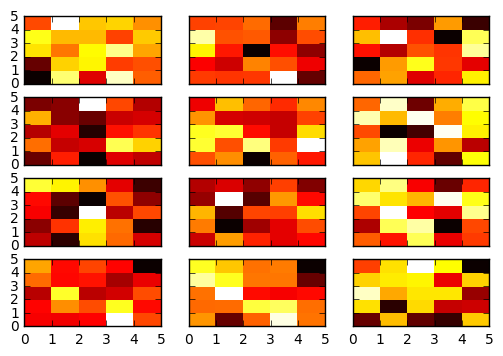

In [70]:
# look at conv filters separately in color channel
f, con = plt.subplots(4,3, sharex='col', sharey='row')
for row in range(4):
    for col in range(3):
        con[row,col].pcolormesh(W[0][row,col],cmap=plt.cm.hot)

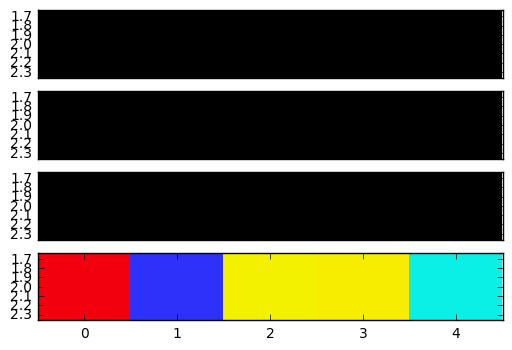

In [71]:
# combine color channels into on filter image
f, con = plt.subplots(4,1, sharex='col', sharey='row')
for row in range(4):
    con[row].imshow(W[0][row].transpose((1,2,0)),
interpolation="none")

In [72]:
preds = model.predict([speedx,imgs])
steer_preds = preds.reshape([-1])

INFO (theano.gof.compilelock): Refreshing lock /home/franciscodeaqui/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/lock_dir/lock


In [73]:
%matplotlib inline

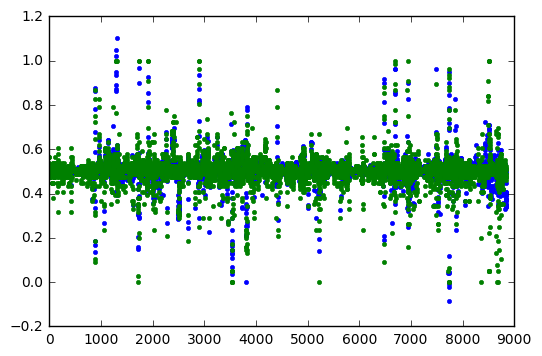

In [74]:
plt.plot(np.array([steer_preds.reshape(len(steer_preds)),targets[:,0]]).T,'.')

In [76]:
def get_point(s,start=0,end=63,height= 16):
    X = int(s*(end-start))
    if X < start:
        X = start
    if X > end:
        X = end
    return (X,height)

In [77]:
mse = []
all_preds = []
weights = sorted(glob.glob('steer_nodrop*.h5'),
        key = lambda x: int(x.split('_')[4]) )
val_idx = (len(imgs)//10) * 9

In [78]:
for wfile in tqdm(weights):
    model.load_weights(wfile)
    preds = model.predict([speedx[val_idx:],imgs[val_idx:]])
    steer_preds = preds.reshape([-1])
    all_preds.append(steer_preds)
    mse.append(metrics.mean_squared_error(targets[val_idx:,0],steer_preds))


0it [00:00, ?it/s]


In [82]:
#plt.plot(np.array([steer_preds.reshape(len(steer_preds)),targets[val_idx:,0]]).T,'.')
#plt.plot(mse)

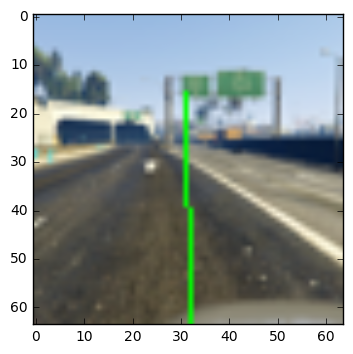

In [84]:
import matplotlib.animation as animation
figure = plt.figure()
imageplot = plt.imshow(np.zeros((64, 64, 3), dtype=np.uint8))
def next_frame(i):
    im = Image.fromarray(np.array(imgs[val_idx+i].transpose(1,2,0),dtype=np.uint8))
    p = get_point(1-steer_preds[i])
    t = get_point(1-targets[i+val_idx,0])
    draw = ImageDraw.Draw(im) 
    draw.line((32,63, p,p),
                fill=(255,0,0,128))
    draw.line((32,63, t,t),
                fill=(0,255,0,128))
    imageplot.set_array(im)
    #if i % 10 == 0:
    #    print(i)
    return imageplot,
animate = animation.FuncAnimation(figure, next_frame, frames=range(0,len(imgs)), interval=25, blit=False)
plt.show()

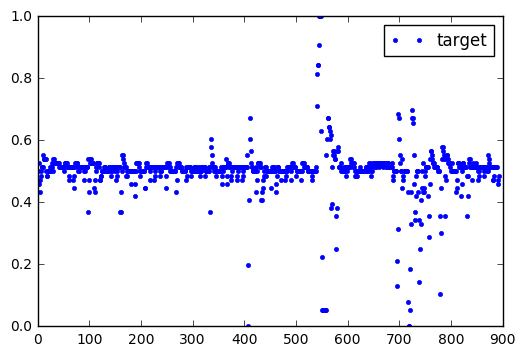

In [85]:
# Muck with default symbol cycler
from itertools import cycle, product
from cycler import cycler
C1 = plt.rcParams['axes.prop_cycle']
C = [c['color'] for c in list(C1)]
sym = [".","x","+","v"]
S1 = cycler('marker',sym)
#P = ['{0}{1}'.format(c,s) for c,s in product(C,sym)]
P = S1*C1
plt.rc('axes', prop_cycle=P)
lines = plt.plot(np.array( [targets[val_idx:,0]] + [sp.reshape(len(steer_preds)) for sp in all_preds]).T, linestyle='')
plt.legend(lines, ['target'] + [str(i) for i in range(len(all_preds))])

## Return to trans.py

In [126]:
from tqdm import tqdm

imgs = np.load('data/imgs_arr_big.npz')['arr_0']
speedx = np.load('data/speedx_arr_big.npz')['arr_0']
targets = np.load('data/targets_arr_big.npz')['arr_0']

In [127]:
nb_epoch = 10
mini_epoch = 1
num_steps = int(nb_epoch/mini_epoch)

In [128]:
import models
from trans, import fire_module, get_squeezenet_trans, get_squeezenet_mini_trans
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

In [133]:
def fire_module(x, squeeze=16, expand=64, trainable = True):
    x = Convolution2D(squeeze, 1, 1, border_mode='valid')(x)
    x = Activation('relu')(x)

    left = Convolution2D(expand, 1, 1, border_mode='valid')(x)
    left = Activation('relu')(left)

    right = ZeroPadding2D(padding=(1, 1))(x)
    right = Convolution2D(expand, 3, 3, border_mode='valid')(right)
    right = Activation('relu')(right)

    y = merge([left, right], mode='concat', concat_axis=1)
    return y
def get_squeezenet_trans( img_size = (64,64)):
    input_img = Input(shape=(3, img_size[0], img_size[1]))
    x = Convolution2D(96, 7, 7, subsample=(2, 2), border_mode='valid', trainable=False)(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)

    # Otto takes over
    # speed, accel, distance, angle
    real_in = Input(shape=(2,), name='real_input')

    flat = Flatten()(x)
    M = merge([flat,real_in], mode='concat', concat_axis=1)
    D1 = Dense(16,W_regularizer=l2(wr), init='lecun_uniform')(M)
    ED1 = ELU()(D1)
    DED1 = Dropout(dp)(ED1)

    S1 = Dense(64,W_regularizer=l2(wr), init='lecun_uniform')(DED1)
    ES1 = ELU()(S1)

    Steer_out = Dense(1, activation='linear', name='steer_out', init='lecun_uniform')(ES1)

    model = Model(input=[real_in, input_img], output=[Steer_out])
    return model

def get_squeezenet_mini_trans( img_size = (64,64)):
    input_img = Input(shape=(3, img_size[0], img_size[1]))
    x = Convolution2D(96, 7, 7, subsample=(2, 2), border_mode='valid')(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Otto takes over
    # speed, accel, distance, angle
    real_in = Input(shape=(2,), name='real_input')

    flat = Flatten()(x)
    M = merge([flat,real_in], mode='concat', concat_axis=1)
    D1 = Dense(256,W_regularizer=l2(wr), init='lecun_uniform')(M)
    ED1 = ELU()(D1)
    DED1 = Dropout(dp)(ED1)

    S1 = Dense(64,W_regularizer=l2(wr), init='lecun_uniform')(DED1)
    ES1 = ELU()(S1)

    Steer_out = Dense(1, activation='linear', name='steer_out', init='lecun_uniform')(ES1)

    model = Model(input=[real_in, input_img], output=[Steer_out])
    return model

In [134]:
M = get_squeezenet_mini_trans((nrows,ncols)) 
adam = Adam(lr=0.001)
M.compile(loss=['mse'],
              optimizer=adam,
metrics=['mse'])

In [135]:
for step in range(0,num_steps):
    h = M.fit([speedx, imgs], {'steer_out':targets[:,0]},
             batch_size = 32, nb_epoch=mini_epoch, verbose=1,
              validation_split=0.1, shuffle=True)
    model.save_weights('transfer_{0}_{1:4.5}.h5'.format(step,h.history['val_loss'][-1]),overwrite=True)

INFO (theano.gof.compilelock): Refreshing lock /home/franciscodeaqui/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/lock_dir/lock


Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 250s - loss: 158815.0273 - mean_squared_error: 158814.9777 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 257s - loss: 0.0546 - mean_squared_error: 0.0173 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 292s - loss: 0.0494 - mean_squared_error: 0.0170 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 304s - loss: 0.0469 - mean_squared_error: 0.0167 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 352s - loss: 0.0455 - mean_squared_error: 0.0165 - val_l

KeyboardInterrupt: 